## Solving Differential Equations for Swinging Atwood Machine (SAM)

This is a rough draft of the code eventually used for the final project.  The equations we are solving are:

$
\begin{align*}
\dot{\theta} = \frac{\partial \mathscr{H}}{\partial p_{\theta}} = \frac{p_{\theta}}{m_{1}\,r^{2}} \qquad&\qquad\qquad \dot{p_{\theta}} = -\frac{\partial \mathscr{H}}{\partial \theta} = -m_{1}\,g\,r\,\sin{\theta} \\
\dot{r} = \frac{\partial \mathscr{H}}{\partial p_{r}} = \frac{p_{r}}{(m_{1}+m_{2})} \qquad&\qquad\qquad \dot{p_{r}} = -\frac{\partial \mathscr{H}}{\partial r} = \frac{p_{\theta}^{2}}{m_{1}\,r^{3}} \,-\, m_{2}\,g \,+\, m_{1}\,g\,\cos{\theta} \\
\end{align*}
$

In [1]:
import numpy as np
import math
import scipy
from scipy.integrate import odeint
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
import matplotlib.cm as cmx
cmap = cmx.get_cmap('spring')
from scipy.signal import argrelextrema

cool = cm = plt.get_cmap('spring') 
cNorm  = colors.Normalize(0., 31)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cool)

g = 9.8

M = np.array([1.0025, 1.01003, 1.02264, 1.04043, 1.06352, 1.09207,
              1.12621, 1.1661, 1.21184, 1.2635, 1.32107, 1.38444,
              1.4534, 1.52765, 1.60673, 1.69009, 1.7771, 1.86702,
              1.95908, 2.05248, 2.14642, 2.2401, 2.33278, 2.42379,
              2.51248, 2.59835, 2.68093, 2.75988, 2.83497, 2.90608,
              2.97321])
theta0 = np.linspace(.1, 3.1, 31)

#theta is the angle between the vertical and the swinging pendulum.
#r is the distance from the swinging mass to the point of rotation. 
#p_theta is the angular momentum of the mass. 
#p_r is the linear momentum of the swinging mass 2, pointing in the direction of the radius.
#m1 is the mass moving vertically
#m2 is the swinging mass. 

def dtheta(theta, r, p_theta, p_r, m1, m2):#calculates change in theta
    return p_theta / (m1 * (r**2))

def dr(theta, r, p_theta, p_r, m1, m2):#this is the change in radius caused by the vertical motion of m1
    return p_r / (m1 + m2)

def dp_theta(theta, r, p_theta, p_r, m1, m2):#change in rotational momentum
    return (-1 * m1 * g * r * np.sin(theta))

def dp_r(theta, r, p_theta, p_r, m1, m2):#change in linear momentum due to changing radius
    return ((p_theta**2) / (m1 * r**3)) - (m2 * g) + (m1 * g * np.cos(theta))

def dervs(state, t, m1, m2):#summarizes the differential equations defined above.
    theta, r, p_theta, p_r = state
    return [dtheta(theta, r, p_theta, p_r, m1, m2),
            dr(theta, r, p_theta, p_r, m1, m2),
            dp_theta(theta, r, p_theta, p_r, m1, m2),
            dp_r(theta, r, p_theta, p_r, m1, m2)]

def Solve_SAM(m1, m2, theta0, r0, p_theta0, p_r0, deriv, tf, dt):
    initial = [theta0, r0, p_theta0, p_r0]
    t = np.linspace(0,tf,round(tf/dt))
    soln_SAM = scipy.integrate.odeint(deriv, initial, t, args = (m1, m2,))
    return soln_SAM, t

def phase_space_plots(X):
    r = X[0][:,1]
    theta = X[0][:,0] - np.pi/2
    p_r = X[0][:,3]
    p_theta = X[0][:,2]
    theta -= (np.ones_like(theta)*(np.pi/2))
        
    plt.figure(figsize=(10,10))

    ax = plt.subplot2grid((1,1), (0,0), projection='polar')
    plt.plot(theta, r)
    plt.show()

    plt.figure(figsize=(10,10))

    ax = plt.subplot2grid((3,2), (0,0))
    plt.plot(r, theta)
    plt.title('r, theta')

    ax = plt.subplot2grid((3,2), (0,1))
    plt.plot(r, p_r)
    plt.title('r, p_r')

    ax = plt.subplot2grid((3,2), (1,0))
    plt.plot(r, p_theta)
    plt.title('r, p_theta')

    ax = plt.subplot2grid((3,2), (1,1))
    plt.plot(theta, p_r)
    plt.title('theta, p_r')

    ax = plt.subplot2grid((3,2), (2,0))
    plt.plot(theta, p_theta)
    plt.title('theta, p_theta')

    ax = plt.subplot2grid((3,2), (2,1))
    plt.plot(p_r, p_theta)
    plt.title('p_r, p_theta')

    plt.show()
    
def z_slice(X, Y, Z, z0):
    indices = []
    Z += np.ones_like(Z)*(-min(Z) - z0)
    for i in range(len(Z)-1):
        prior = Z[i]
        follw = Z[i+1]
        if follw == 0:
            if i != 0:
                indices.append(i)
        else:
            if i != 0:
                if (prior/follw) < 0:
                    indices.append(i)
    new_X = X[np.array(indices)]
    new_Y = Y[np.array(indices)]
    return new_X, new_Y

def deep_z_slice(W, X, Y, Z, z0):
    indices = []
    Z += np.ones_like(Z)*(-min(Z) - z0)
    for i in range(len(Z)-1):
        prior = Z[i]
        follw = Z[i+1]
        if follw == 0:
            if i != 0:
                indices.append(i)
        else:
            if i != 0:
                if (prior/follw) < 0:
                    indices.append(i)
    new_W = W[np.array(indices)]
    new_X = X[np.array(indices)]
    new_Y = Y[np.array(indices)]
    return new_W, new_X, new_Y

def plot_slices(X, Y, Z):
    slices = np.linspace(.01,.99,10)
    Z_range = max(Z) - min(Z)
    z0s = Z_range * np.array(slices)
    
    cool = cm = plt.get_cmap('Spectral') 
    cNorm  = colors.Normalize(0., len(z0s))
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cool)

    plt.figure(figsize=(10,10))
    for i in range(len(z0s)):
        level = z_slice(X, Y, Z, z0s[i])
        plt.plot(level[0], level[1], '.', color=scalarMap.to_rgba(i))
    plt.show()
    
def threeD_plot(X, Y, Z):
    from mpl_toolkits.mplot3d import Axes3D
    fig = plt.figure(figsize=(20,20))
    ax = fig.gca(projection='3d')
    ax.plot(X, Y, Z)
    plt.show()
    
def Differences(X):
    T = np.array(argrelextrema(X, np.greater))[0]
    diffs = []
    for i in range(int(round(len(T)/2))-2):
        start1 = 0 + T[2*i]
        end1 = T[(2*i) + 1] - 1
        start2 = 0 + T[2*(i+1)]
        end2 = T[(2*(i+1)) + 1] - 1
        
        range1 = end1 - start1
        range2 = end2 - start2
        drange = range2 - range1
        
        if drange != 0:
            end2 -= drange
            range2 = end2 - start2
        
        area = sum(abs(X[start1:end1] - X[start2:end2]))
        diffs.append(area)
    return diffs

def Bifurcation(M0, Mf, NM):
    plt.figure(figsize=(30,7))
    M = np.linspace(M0, Mf, NM)
    for i in range(len(M)):
        radii = Solve_SAM(1., M[i], np.pi / 2, .1, 0., 0., dervs, 100, .001)[0][:,1]
        areas = Differences(radii)
        x_value = M[i] * np.ones_like(areas)
        plt.plot(x_value, areas, 'b.')
    plt.ylim([0,10])
    plt.show()
    
def BifurcationColor(M0, Mf, NM):
    cool = cm = plt.get_cmap('YlGnBu') 
    cNorm  = colors.Normalize(0., 5.)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cool)
    
    plt.figure(figsize=(30,7))
    
    M = np.linspace(M0, Mf, NM)
    for i in range(len(M)):
        radii = Solve_SAM(1., M[i], np.pi / 2, .1, 0., 0., dervs, 1000, .001)[0][:,1]
        areas = np.array(Differences(radii))
        p_areas = np.round(areas*100)/100
        if len(set(p_areas)) < 2:
            p_areas[0] += .001
        freq = np.histogram(p_areas, int(300*(max(p_areas)-min(p_areas))+1))
        
        for j in range(len(np.array(freq[1]))-1):
            colorVal = scalarMap.to_rgba(np.array(freq[0])[j])
            plt.plot(M[i], np.array(freq[1])[j], '.', ms=2,color=colorVal)
    
    plt.ylim([0,15])
    plt.show()
    
def get_min_places(X, Y, Z):
    indices = argrelextrema(Z, np.less)
    new_X = X[indices]
    new_Y = Y[indices]
    return new_X, new_Y
    
def get_p_r(E, M, r, theta, p_theta):
    return ( ( E - (p_theta**2/(2*r**2)) - (M*g*r) + (g*r*np.cos(theta)) )*( 2*(M+1) ) )

def SOS_maps(E, M, nTs, nDt, N):
    cool = cm = plt.get_cmap('Accent') 
    cNorm  = colors.Normalize(0., nTs*nDt)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cool)
    
    R0 = .9
    it = 0
    for i in range(nTs):
        theta = Ts[i]
        for j in range(nDt):
            p_theta = Dt[j]
            p_r = get_p_r(E, M, R0, theta, p_theta)
            X = Solve_SAM(1., M, theta, R0, p_theta, p_r, dervs, N, .001)
            ar = X[0][:,1]
            atheta = X[0][:,0]
            ap_r = X[0][:,3]
            ap_theta = X[0][:,2]

            Y = get_min_places(ar, ap_r, atheta)
            some_r = Y[0]
            some_theta = Y[1]
            plt.plot(some_r, some_theta, '.', 
                     label=r'$\theta$={0}, $P_\theta$={1}'.format(str(theta)[:5], p_theta),
                     color=scalarMap.to_rgba(nTs*i+j))
            it += 1
    #plt.legend()
    plt.xlabel('r')
    plt.ylabel(r'$\dot{r}$')
    plt.title('M = {0}'.format(str(M)[:3]))

def three_SOS_maps(E, M0, Mf, N):
    Ms = np.linspace(M0, Mf, 9)
    print(Ms)
    Ts = np.linspace(np.pi/4, 3*np.pi/3, 3)
    Dt = np.linspace(0, 5, 3)
    
    plt.figure(figsize=(20,20))
    for i in range(3):
        for j in range(3):
            ax = plt.subplot2grid((3, 3), (i, j))
            SOS_maps(E, Ms[(3*i)+j], int(len(Ts)), int(len(Dt)), N)

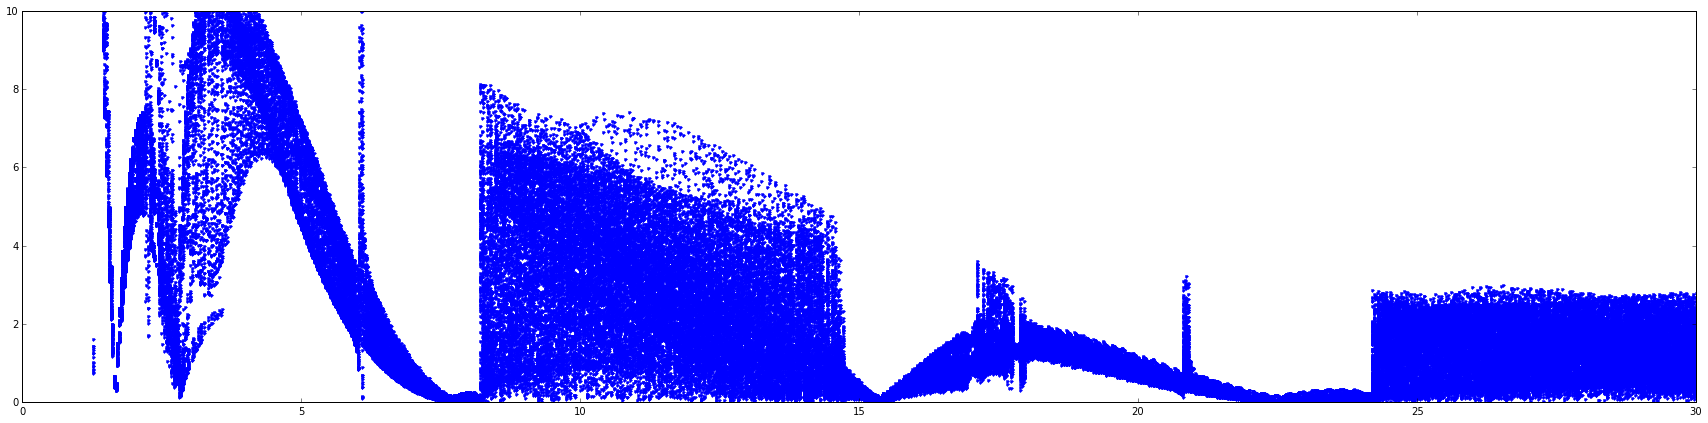

In [9]:
Bifurcation(1.1, 30, 1001)

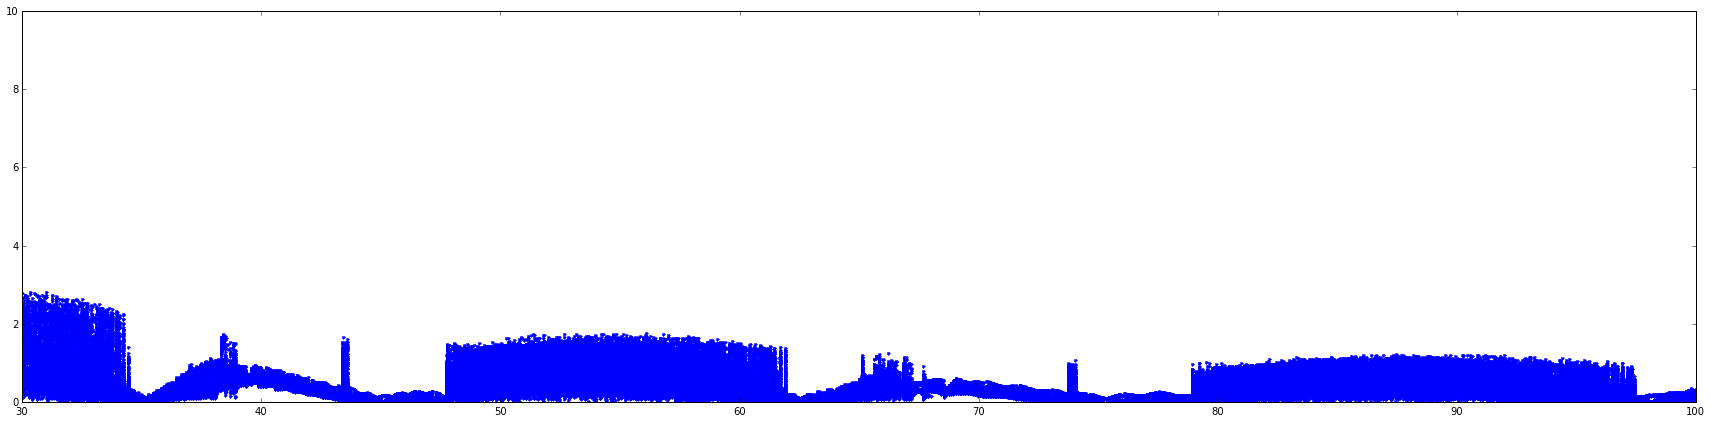

In [35]:
Bifurcation(30, 100, 1001)

In [37]:
MMM = 7.

In [48]:
X = Solve_SAM(1., MMM, np.pi / 2., .1, 0., 0., dervs, 10, .001)
r = X[0][:,1]
theta = X[0][:,0]
p_r = X[0][:,3]
p_theta = X[0][:,2]
SLICE = z_slice(r, p_r, theta, 0.00001)

#phase_space_plots(X)

(array([ 326,  968, 1597, 2232, 2883, 3531, 4163, 4793, 5439, 6090, 6728,
       7357, 7996, 8648, 9292, 9922]),)


[ 1.1     1.2375  1.375   1.5125  1.65    1.7875  1.925   2.0625  2.2   ]


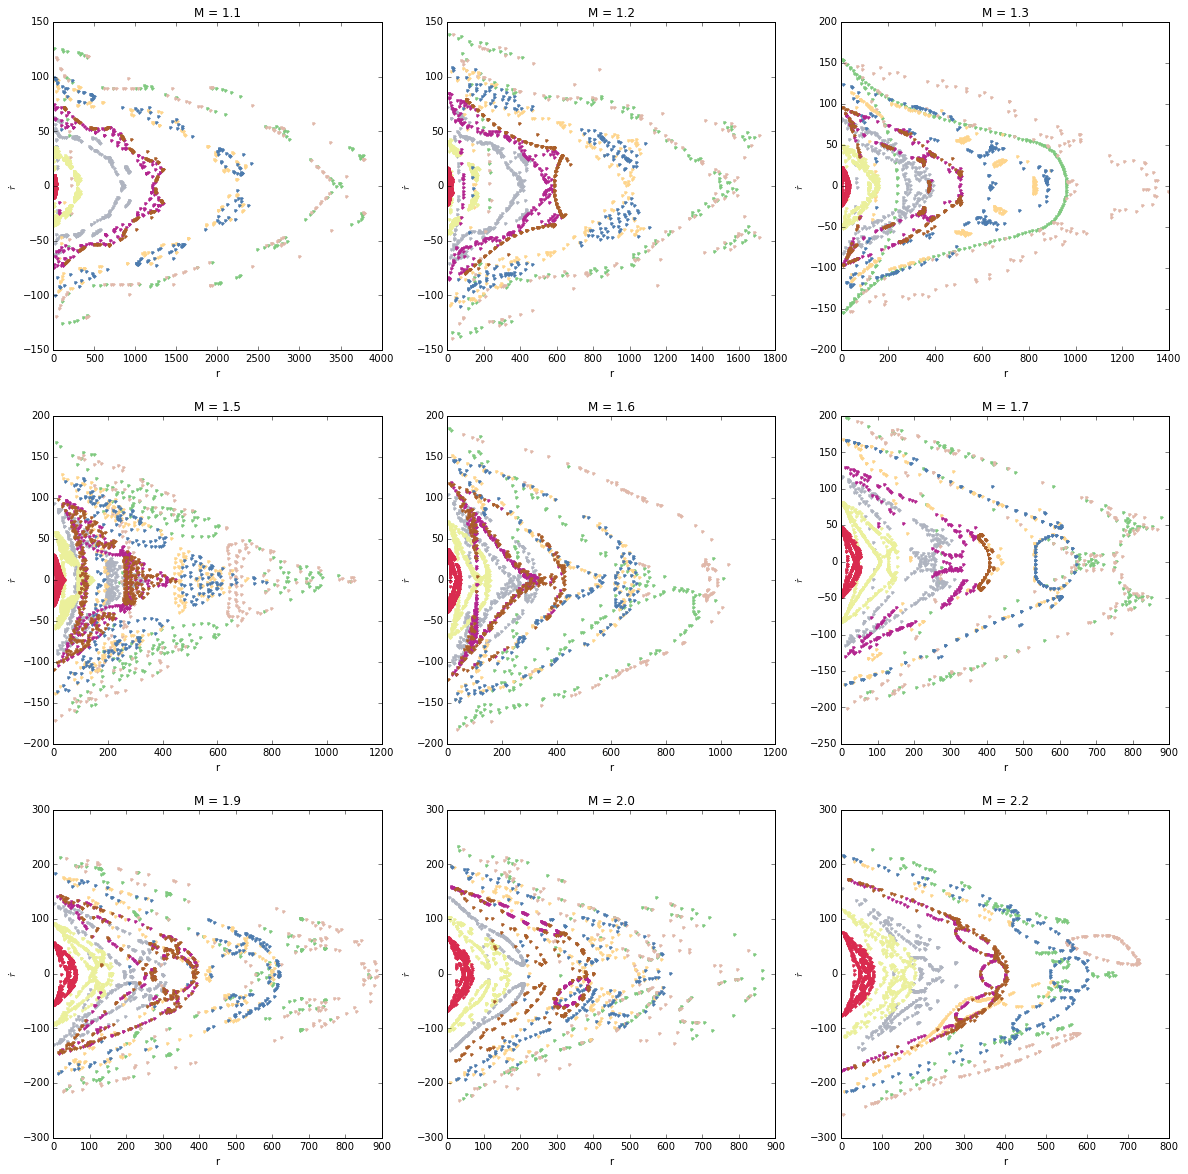

In [100]:
three_SOS_maps(1, 1.1, 2.2, 10000)

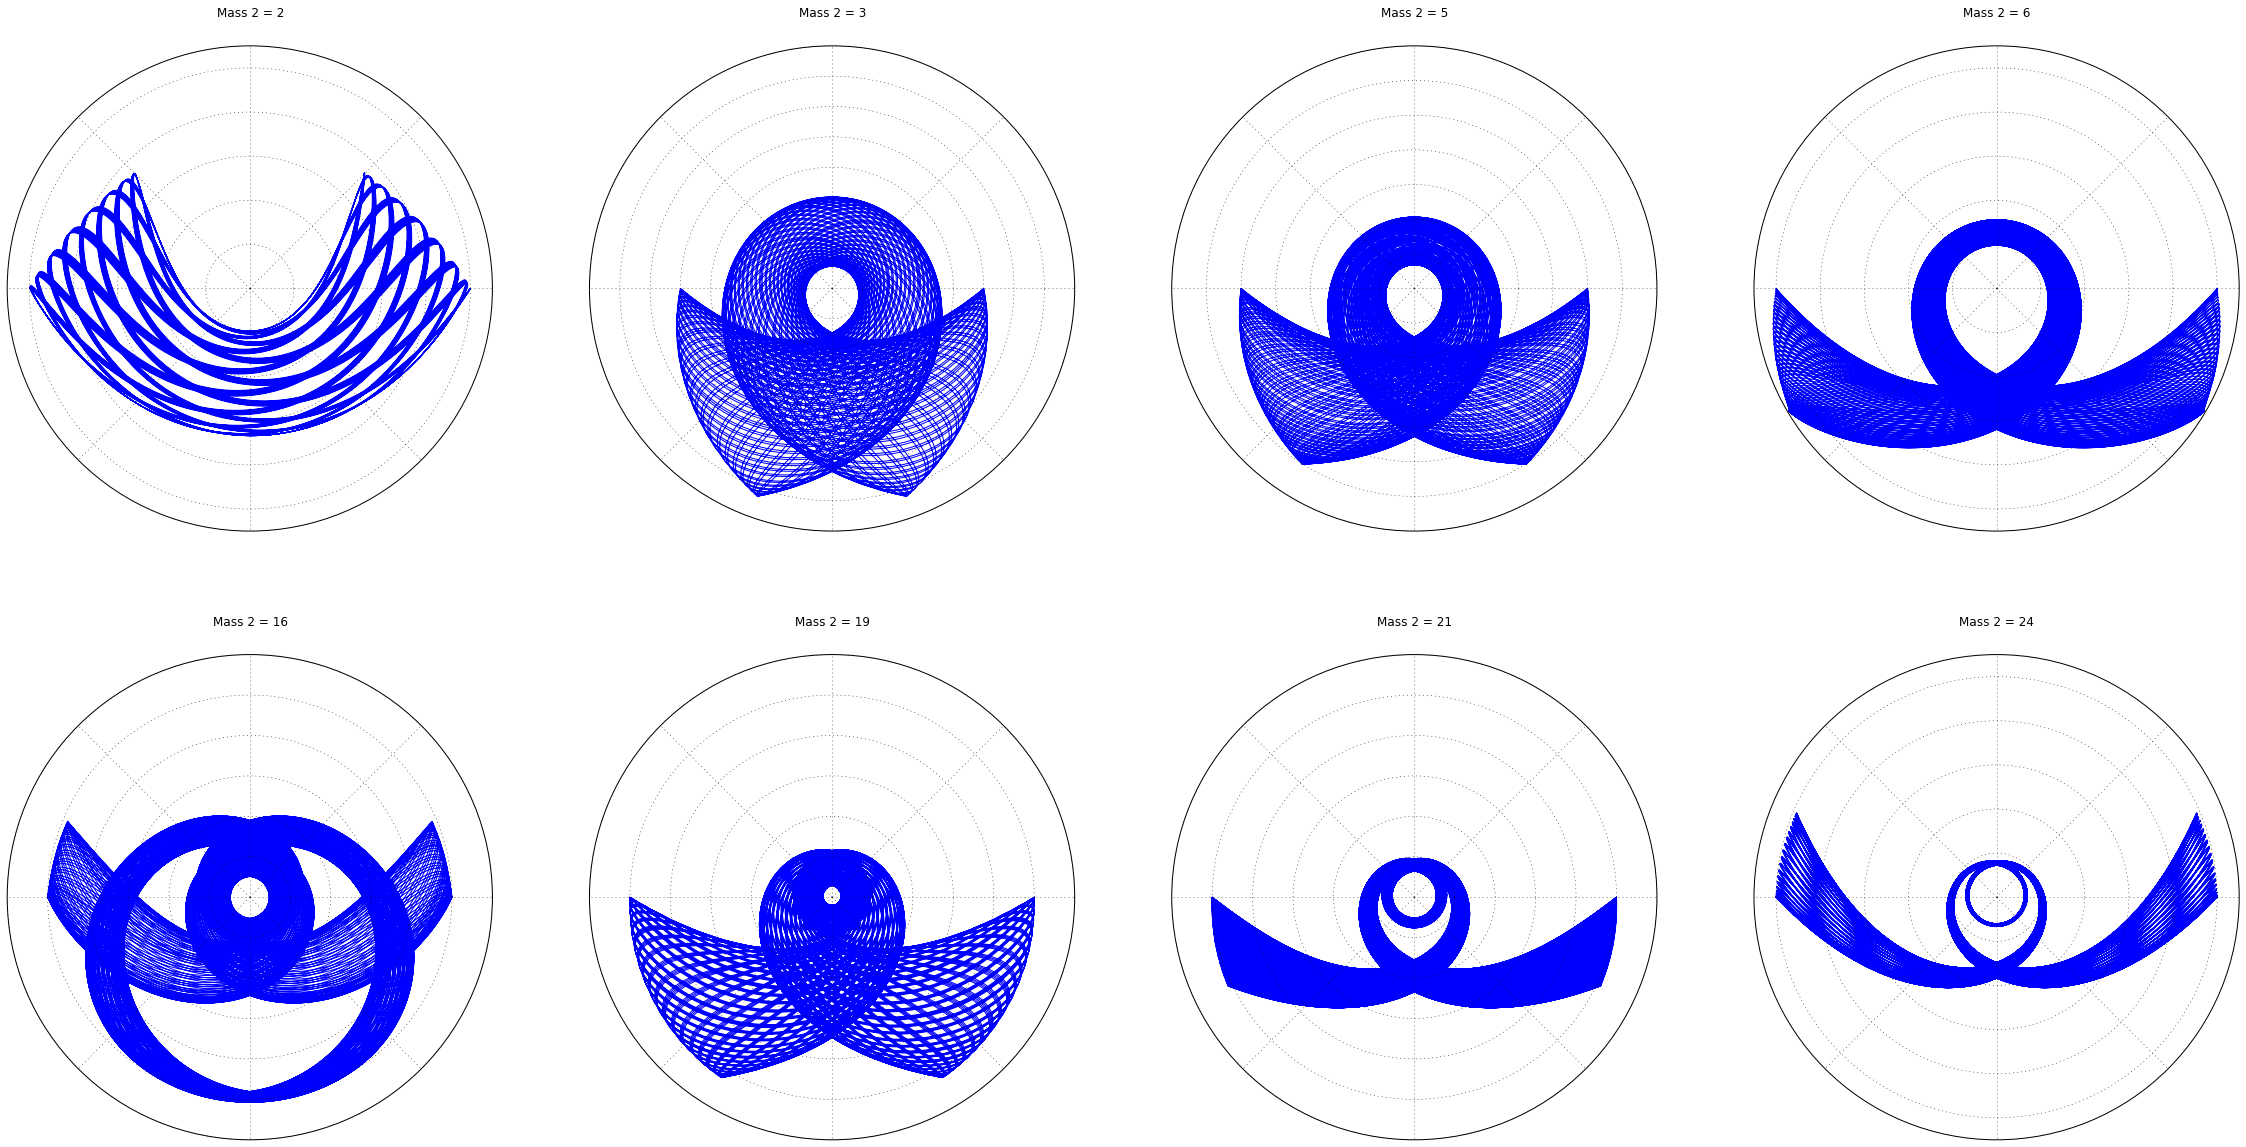

In [15]:
plt.figure(figsize=(40,20))

MMM = 2
ax = plt.subplot2grid((2,4),(0,0) ,projection='polar')
plt.plot(Solve_SAM(1., MMM, np.pi / 2., .1, 0., 0., dervs, 50, .001)[0][:,0] - 
         np.ones_like(Solve_SAM(1., MMM, np.pi / 2., .1, 0., 0., dervs, 50, .001)[0][:,0])*
          (np.pi/2),
         Solve_SAM(1., MMM, np.pi / 2., .1, 0., 0., dervs, 50, .001)[0][:,1])
plt.title('Mass 2 = %s' % MMM)
ax.set_xticklabels([])
ax.set_yticklabels([])

MMM = 3
ax = plt.subplot2grid((2,4),(0,1) ,projection='polar')
plt.plot(Solve_SAM(1., MMM, np.pi / 2., .1, 0., 0., dervs, 50, .001)[0][:,0] - 
         np.ones_like(Solve_SAM(1., MMM, np.pi / 2., .1, 0., 0., dervs, 50, .001)[0][:,0])*
          (np.pi/2),
         Solve_SAM(1., MMM, np.pi / 2., .1, 0., 0., dervs, 50, .001)[0][:,1])
plt.title('Mass 2 = %s' % MMM)
ax.set_xticklabels([])
ax.set_yticklabels([])

MMM = 5
ax = plt.subplot2grid((2,4),(0,2) ,projection='polar')
plt.plot(Solve_SAM(1., MMM, np.pi / 2., .1, 0., 0., dervs, 50, .001)[0][:,0] - 
         np.ones_like(Solve_SAM(1., MMM, np.pi / 2., .1, 0., 0., dervs, 50, .001)[0][:,0])*
          (np.pi/2),
         Solve_SAM(1., MMM, np.pi / 2., .1, 0., 0., dervs, 50, .001)[0][:,1])
plt.title('Mass 2 = %s' % MMM)
ax.set_xticklabels([])
ax.set_yticklabels([])

MMM = 6
ax = plt.subplot2grid((2,4),(0,3) ,projection='polar')
plt.plot(Solve_SAM(1., MMM, np.pi / 2., .1, 0., 0., dervs, 50, .001)[0][:,0] - 
         np.ones_like(Solve_SAM(1., MMM, np.pi / 2., .1, 0., 0., dervs, 50, .001)[0][:,0])*
          (np.pi/2),
         Solve_SAM(1., MMM, np.pi / 2., .1, 0., 0., dervs, 50, .001)[0][:,1])
plt.title('Mass 2 = %s' % MMM)
ax.set_xticklabels([])
ax.set_yticklabels([])

MMM = 16
ax = plt.subplot2grid((2,4),(1,0) ,projection='polar')
plt.plot(Solve_SAM(1., MMM, np.pi / 2., .1, 0., 0., dervs, 50, .001)[0][:,0] - 
         np.ones_like(Solve_SAM(1., MMM, np.pi / 2., .1, 0., 0., dervs, 50, .001)[0][:,0])*
          (np.pi/2),
         Solve_SAM(1., MMM, np.pi / 2., .1, 0., 0., dervs, 50, .001)[0][:,1])
plt.title('Mass 2 = %s' % MMM)
ax.set_xticklabels([])
ax.set_yticklabels([])

MMM = 19
ax = plt.subplot2grid((2,4),(1,1) ,projection='polar')
plt.plot(Solve_SAM(1., MMM, np.pi / 2., .1, 0., 0., dervs, 50, .001)[0][:,0] - 
         np.ones_like(Solve_SAM(1., MMM, np.pi / 2., .1, 0., 0., dervs, 50, .001)[0][:,0])*
          (np.pi/2),
         Solve_SAM(1., MMM, np.pi / 2., .1, 0., 0., dervs, 50, .001)[0][:,1])
plt.title('Mass 2 = %s' % MMM)
ax.set_xticklabels([])
ax.set_yticklabels([])

MMM = 21
ax = plt.subplot2grid((2,4),(1,2) ,projection='polar')
plt.plot(Solve_SAM(1., MMM, np.pi / 2., .1, 0., 0., dervs, 50, .001)[0][:,0] - 
         np.ones_like(Solve_SAM(1., MMM, np.pi / 2., .1, 0., 0., dervs, 50, .001)[0][:,0])*
          (np.pi/2),
         Solve_SAM(1., MMM, np.pi / 2., .1, 0., 0., dervs, 50, .001)[0][:,1])
plt.title('Mass 2 = %s' % MMM)
ax.set_xticklabels([])
ax.set_yticklabels([])

MMM = 24
ax = plt.subplot2grid((2,4),(1,3) ,projection='polar')
plt.plot(Solve_SAM(1., MMM, np.pi / 2., .1, 0., 0., dervs, 50, .001)[0][:,0] - 
         np.ones_like(Solve_SAM(1., MMM, np.pi / 2., .1, 0., 0., dervs, 50, .001)[0][:,0])*
          (np.pi/2),
         Solve_SAM(1., MMM, np.pi / 2., .1, 0., 0., dervs, 50, .001)[0][:,1])
plt.title('Mass 2 = %s' % MMM)
ax.set_xticklabels([])
ax.set_yticklabels([])

plt.show()